In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01, seed=42):
        """
        Initialization:
        - Initialize weights with small random values.
        - Initialize biases to zeros.
        """
        np.random.seed(seed)
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01  # Weight matrix for input -> hidden layer
        self.b1 = np.zeros((1, hidden_dim))                        # Bias vector for hidden layer
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01   # Weight matrix for hidden -> output layer
        self.b2 = np.zeros((1, output_dim))                        # Bias vector for output layer
        self.learning_rate = learning_rate

    def relu(self, Z):
        """ReLU activation function."""
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        """Derivative of ReLU activation."""
        return (Z > 0).astype(float)

    def forward(self, X):
        """
        Forward Propagation:
        1. Compute Z1 = X * W1 + b1 for the hidden layer.
        2. Apply ReLU activation: A1 = ReLU(Z1).
        3. Compute Z2 = A1 * W2 + b2 for the output layer.
        4. For regression, use a linear activation at the output: A2 = Z2.
        """
        self.Z1 = np.dot(X, self.W1) + self.b1   # Linear combination for hidden layer
        self.A1 = self.relu(self.Z1)             # Hidden layer activation using ReLU
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # Linear combination for output layer
        self.A2 = self.Z2  # For regression, the output is a linear activation
        return self.A2

    def cost(self, Y, Y_hat):
        """
        Compute Mean Squared Error (MSE) cost.
        Cost = (1/(2*m)) * sum((Y_hat - Y)^2)
        """
        m = Y.shape[0]
        cost = np.sum((Y_hat - Y) ** 2) / (2 * m)
        return cost

    def backward(self, X, Y, Y_hat):
        """
        Backpropagation Algorithm:
        Step 1: (Forward propagation already computed in self.forward)

        Step 2: Compute the partial derivative for the output layer.
            - For MSE: dCost/dY_hat = (Y_hat - Y) / m
            - Since the output activation is linear, dY_hat/dZ2 = 1.
            Therefore, dZ2 = (Y_hat - Y) / m

        Step 3: Compute partial derivatives for the parameters feeding into the output layer.
            - dW2 = A1^T * dZ2
            - db2 = Sum(dZ2, axis=0)

        Step 4: Propagate the error back one layer:
            - Compute dA1 = dZ2 * (W2)^T

        Step 5: Compute the partial derivative of the activation at the hidden layer.
            - Since A1 = ReLU(Z1), dA1/dZ1 = relu_derivative(Z1)
            - Hence, dZ1 = dA1 * relu_derivative(Z1)

        Step 6: Compute partial derivatives for the parameters feeding into the hidden layer.
            - dW1 = X^T * dZ1
            - db1 = Sum(dZ1, axis=0)

        Finally, update all parameters using gradient descent.
        """
        m = X.shape[0]

        # Step 2: Compute gradient at the output layer
        dZ2 = (Y_hat - Y) / m  # dCost/dZ2

        # Step 3: Compute gradients for W2 and b2 (output layer parameters)
        dW2 = np.dot(self.A1.T, dZ2)   # dCost/dW2
        db2 = np.sum(dZ2, axis=0, keepdims=True)  # dCost/db2

        # Step 4: Propagate the error back to the hidden layer
        dA1 = np.dot(dZ2, self.W2.T)   # dCost/dA1

        # Step 5: Compute the derivative of the activation at the hidden layer
        dZ1 = dA1 * self.relu_derivative(self.Z1)  # dCost/dZ1

        # Step 6: Compute gradients for W1 and b1 (hidden layer parameters)
        dW1 = np.dot(X.T, dZ1)        # dCost/dW1
        db1 = np.sum(dZ1, axis=0, keepdims=True)  # dCost/db1

        # Update parameters using gradient descent
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, Y, num_epochs=1000, batch_size=32, print_cost=True):
        """
        Train the neural network using mini-batch gradient descent.
        The data is shuffled each epoch, and gradients are computed on mini-batches.
        """
        m = X.shape[0]
        for epoch in range(num_epochs):
            # Shuffle the data at the start of each epoch.
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]

            # Process mini-batches.
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]

                # Forward propagation for the mini-batch
                Y_hat = self.forward(X_batch)

                # Backpropagation to compute gradients and update parameters
                self.backward(X_batch, Y_batch, Y_hat)

            # Optionally print cost every 100 epochs
            if print_cost and epoch % 100 == 0:
                Y_hat_full = self.forward(X)
                current_cost = self.cost(Y, Y_hat_full)
                print(f"Epoch {epoch}: Cost = {current_cost:.4f}")

    def predict(self, X):
        """
        Make predictions using the trained model.
        """
        return self.forward(X)


filepath = '/content/drive/MyDrive/BERT4Rec_Data/ml-1m/ratings.dat'
ratings = pd.read_csv(filepath, sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Select a random subset of 10,000 samples to reduce inefficient runtimes.
subset = ratings.sample(n=10000, random_state=42)

# Use 'UserID' and 'MovieID' as input features.
X = subset[['UserID', 'MovieID']].values.astype(float)
Y = subset['Rating'].values.reshape(-1, 1)  # The target is the rating.

# Normalize the features (bringing values into the [0,1] range).
X[:, 0] = X[:, 0] / ratings['UserID'].max()   # Normalize UserID
X[:, 1] = X[:, 1] / ratings['MovieID'].max()    # Normalize MovieID

# Split data into training and testing sets (80% training, 20% testing).
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Training and Evaluating the Neural Network

# - Input dimension: 2 (UserID and MovieID)
# - Hidden dimension: 10 (this is adjustable)
# - Output dimension: 1 (predicted rating)
nn = NeuralNetwork(input_dim=2, hidden_dim=10, output_dim=1, learning_rate=0.01)

# Train the network using mini-batch gradient descent to achieve a balance between computaitonal efficiency and convergence stability.
nn.train(X_train, Y_train, num_epochs=1000, batch_size=32, print_cost=True)

# Make predictions on the test set.
predictions = nn.predict(X_test)

# Compute and display the test cost (MSE).
test_cost = nn.cost(Y_test, predictions)
print(f"\nTest Cost (MSE): {test_cost:.4f}")

Epoch 0: Cost = 0.6365
Epoch 100: Cost = 0.6129
Epoch 200: Cost = 0.6125
Epoch 300: Cost = 0.6124
Epoch 400: Cost = 0.6122
Epoch 500: Cost = 0.6108
Epoch 600: Cost = 0.6085
Epoch 700: Cost = 0.6070
Epoch 800: Cost = 0.6061
Epoch 900: Cost = 0.6056

Test Cost (MSE): 0.6074


# Part 2

## Task 1

### **Resources Used:**

1. **[PyTorch Official Build Model Tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)**  
   - This tutorial explains how to define a neural network using `torch.nn.Module`, initialize layers, and implement the `forward()` function. It provides a fundamental understanding of PyTorch's approach to defining models.

2. **[PyTorch Autograd Mechanics](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)**  
   - PyTorch uses automatic differentiation for backpropagation. This tutorial explains how to use `torch.autograd` to compute gradients, which is essential for training neural networks.

3. **[PyTorch Optimizer Guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)**  
   - Training a neural network requires an optimization algorithm such as Stochastic Gradient Descent (SGD) or Adam. This guide details how to use `torch.optim` for updating model parameters.

4. **[PyTorch Loss Functions Documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)**  
   - To train a model, we need to compute the loss. This documentation outlines various loss functions (e.g., `torch.nn.CrossEntropyLoss`, `torch.nn.MSELoss`).

5. **[PyTorch Data Loading and Preprocessing](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)**  
   - This tutorial explains `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, which are needed to efficiently load and preprocess data.

---

### **Why These Resources Were Needed?**

1. **Building the Model (`torch.nn.Module`)**  
   - Needed to define a 2-layer neural network, specifying the layers (`torch.nn.Linear`) and activation functions.
  
2. **Forward Propagation (`forward() method`)**  
   - Required to define how input data flows through the layers.
  
3. **Backward Propagation (`torch.autograd`)**  
   - Essential for computing gradients during training, enabling the model to learn.
  
4. **Optimization (`torch.optim`)**  
   - Needed to update model parameters based on the computed gradients.
  
5. **Loss Computation (`torch.nn functional`)**  
   - Used to evaluate the model's performance and guide updates to the weights.
  
6. **Data Handling (`torch.utils.data`)**  
   - Ensures efficient loading and batching of training data.



## Task 2

First few rows of the ratings data:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None

Rating Distribution:
Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64
Training set size: (7000, 2)
Dev set size: (1500, 2)
Test set size: (1500, 2)
TwoLayerNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_feature

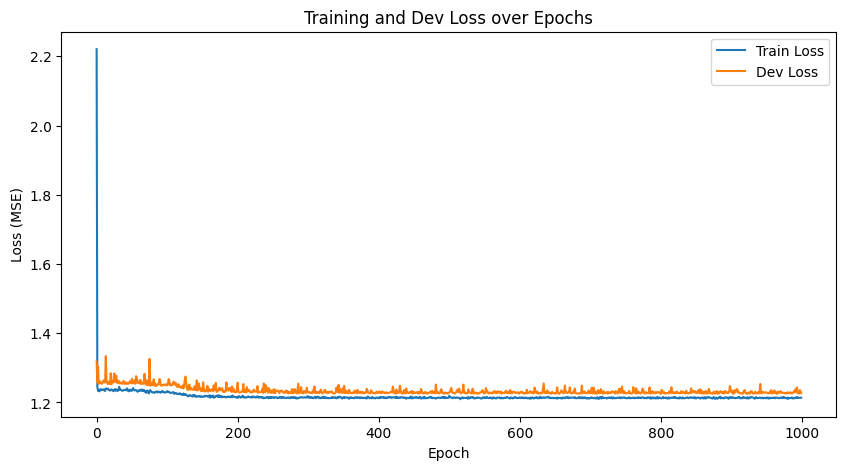

Test Loss (MSE): 1.1932


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Load the MovieLens 1M ratings data.
# The ratings file uses "::" as the delimiter.
filepath = '/content/drive/MyDrive/BERT4Rec_Data/ml-1m/ratings.dat'
ratings = pd.read_csv(filepath, sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])


# 1. Exploratory Data Analysis (EDA)

#%% [code]
print("First few rows of the ratings data:")
print(ratings.head())

print("\nDataset Info:")
print(ratings.info())

print("\nRating Distribution:")
print(ratings['Rating'].value_counts().sort_index())

# 2. Data Preprocessing and Train-Dev-Test Split

# Select a random subset of 10,000 samples. We use the `UserID` and `MovieID` as features (converted to floats) and the `Rating` as the target.
subset = ratings.sample(n=10000, random_state=42)

# Extract features and target
X = subset[['UserID', 'MovieID']].values.astype(np.float32)
Y = subset['Rating'].values.astype(np.float32)

# Normalize features to [0,1]
X[:, 0] /= ratings['UserID'].max()   # Normalize UserID
X[:, 1] /= ratings['MovieID'].max()    # Normalize MovieID

# Split into train, development, and test sets (70% train, 15% dev, 15% test)
from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Dev set size:", X_dev.shape)
print("Test set size:", X_test.shape)

# 3. Convert Data to PyTorch Tensors and Create DataLoaders

# PyTorch requires data in tensor format. Create DataLoader objects for batching and shuffling during training.

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_dev_tensor   = torch.tensor(X_dev, dtype=torch.float32)
Y_dev_tensor   = torch.tensor(Y_dev, dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor  = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
dev_dataset   = TensorDataset(X_dev_tensor, Y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=32, shuffle=False)


# 4. Define the 2-Layer Neural Network Model

# NN Architecture:
# - **Input Layer:** 2 features (UserID and MovieID)
# - **Hidden Layer:** 10 neurons with ReLU activation
# - **Output Layer:** 1 neuron (for regression, using a linear activation)

# The model is defined as a subclass of `torch.nn.Module`, and the forward propagation is implemented in the `forward()` method.

import torch.nn as nn

class TwoLayerNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=1):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First layer
        self.relu = nn.ReLU()                        # ReLU activation
        self.fc2 = nn.Linear(hidden_dim, output_dim) # Second (output) layer

    def forward(self, x):
        # Forward propagation:
        # 1. Compute hidden layer pre-activation: x @ fc1.weight^T + fc1.bias
        # 2. Apply ReLU activation
        # 3. Compute output layer: hidden_activation @ fc2.weight^T + fc2.bias
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Instantiate the model
model = TwoLayerNet(input_dim=2, hidden_dim=10, output_dim=1)
print(model)


# 5. Define the Loss Function and Optimizer

# Use Mean Squared Error (MSE) as the loss function (cost function) and the Adam optimizer (a variant of gradient descent) to update the network's parameters.

# Hyperparameters:
# - Learning Rate: 0.01
# - Batch Size: 32
# - Number of Epochs: 1000


import torch.optim as optim

criterion = nn.MSELoss()            # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

# 6. Train the Neural Network

# Train the model using mini-batch gradient descent. At each epoch, compute the training loss and also evaluate the loss on the development set. Loss curves are stored for later visualization.

num_epochs = 1000
train_losses = []
dev_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()       # Clear gradients from previous step
        outputs = model(batch_x)      # Forward propagation
        loss = criterion(outputs, batch_y)  # Compute loss (cost)
        loss.backward()               # Backward propagation (compute gradients)
        optimizer.step()              # Update parameters
        batch_losses.append(loss.item())

    # Compute average training loss for the epoch
    avg_train_loss = np.mean(batch_losses)
    train_losses.append(avg_train_loss)

    # Evaluate on the development set
    model.eval()
    with torch.no_grad():
        dev_loss = 0.0
        total_samples = 0
        for batch_x, batch_y in dev_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            dev_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)
        avg_dev_loss = dev_loss / total_samples
        dev_losses.append(avg_dev_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Dev Loss = {avg_dev_loss:.4f}")

# 7. Visualize the Training and Development Loss Curves

# Plotting the loss curves helps in understanding the model’s convergence behavior over epochs.
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Dev Loss over Epochs")
plt.legend()
plt.show()

# 8. Evaluate the Model on the Test Set

# Finally, we evaluate the trained model on the test set and report the Mean Squared Error (MSE).

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, Y_test_tensor)
    print(f"Test Loss (MSE): {test_loss.item():.4f}")

# Task 3

## Hyperparameter Selection and Rationale

### Learning Rate (0.01):
I chose a learning rate of 0.01 as a starting point because it is a commonly used default value with the Adam optimizer. This value allowed the model to converge steadily without causing large, unstable weight updates. In the experiments, the loss decreased smoothly over the epochs, indicating that this learning rate was well suited to the problem.

### Number of Epochs (1000):
Training for 1000 epochs provided sufficient iterations for the network to converge. I monitored the training and development losses and observed that after about 900 epochs the losses had plateaued (with training loss around 1.2105 and dev loss around 1.2252). This suggests that the model was learning effectively and that further training might yield diminishing returns.

### Batch Size (32):
I used a mini-batch size of 32. This choice is a standard one in many deep learning tasks because it strikes a balance between computational efficiency and gradient estimate stability. A batch size of 32 ensures that each weight update is based on enough samples to provide a reliable gradient direction while keeping the computational load manageable.

### Hidden Layer Size (10 neurons):
Given that the input only consists of two features (normalized UserID and MovieID), a hidden layer with 10 neurons was chosen to keep the network relatively simple. This size was sufficient to capture non-linear relationships without over-parameterizing the model, which helps in reducing the risk of overfitting, especially on a subset of 10,000 samples.

### Regularization
In this implementation, I did not incorporate explicit regularization techniques such as L1/L2 regularization or dropout.The decision was based on the simplicity of the network architecture (only one hidden layer with 10 neurons) and the moderate size of the training data (7000 samples in the subset). The comparable performance between the training and development losses suggested that the model was not significantly overfitting. For a simple model like this, adding regularization might have been unnecessary. However, for more complex networks or larger datasets, incorporating regularization could help further control overfitting.

### Optimization Algorithm
I used the Adam optimizer for updating the network parameters. Adam is an adaptive optimization algorithm that adjusts the learning rate for each parameter based on estimates of the first and second moments of the gradients. This makes it particularly effective for handling noisy gradients and for ensuring stable convergence. Compared to vanilla stochastic gradient descent (SGD), Adam tends to converge faster and is less sensitive to the initial learning rate choice. This is especially useful in my project, where a smooth and reliable convergence was observed over the epochs.



# Task 4

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and train the linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, Y_train)

# Predict on the test set
y_test_pred = baseline_model.predict(X_test)

# Calculate the Mean Squared Error (MSE) on the test set
baseline_mse = mean_squared_error(Y_test, y_test_pred)
print("Baseline Linear Regression Test MSE:", baseline_mse)


Baseline Linear Regression Test MSE: 1.2021719217300415


The nearly identical performance of the two models suggests that, for this subset of the MovieLens data (using normalized UserID and MovieID), the relationship to the ratings is largely linear. The neural network's ability to capture non-linear patterns provided only a marginal improvement over linear regression. This highlights that when the features are limited and the underlying relationship is simple, a well-tuned linear model can perform almost as well as a more complex neural network. Linear Regression is simpler, easier to interpret, and sufficient when the relationship is linear. Neural Networks are more powerful for modeling non-linear interactions but might not yield significant gains if the data does not contain complex patterns.